In [ ]:
import typing as tp
from functools import partial
import itertools

import numpy as np
import torch
from torch import nn

import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Our model definition, a classical MLP with ReLU activations


def get_model(n_inputs, n_outputs, hidden_size=128, num_layers=2):
    layers = [nn.Linear(n_inputs, hidden_size), nn.ReLU()]
    for _ in range(num_layers - 2):
        layers.append(nn.Linear(hidden_size, hidden_size))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_size, n_outputs))
    return nn.Sequential(*layers)

In [ ]:
# Our data generator, allowing for noisy and non-noisy data


@torch.no_grad()
def get_batch_generalize_binary(batch_size, num_features=1, noise_std=0.0):
    y = torch.randint(0, 2, (batch_size,))
    x = torch.zeros(batch_size, num_features) + y[:, None]
    if noise_std:
        x += torch.randn_like(x) * noise_std
    return x, y

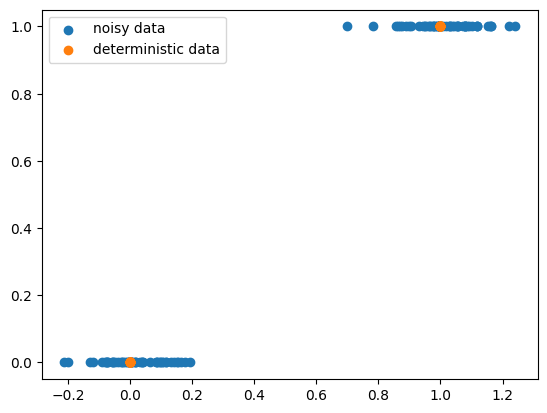

In [ ]:
# A sample of a 100 points drawn from the (non-)noisy distribution

x, y = get_batch_generalize_binary(100, noise_std=0.1)
plt.scatter(x[:, 0], y, label="noisy data")
x, y = get_batch_generalize_binary(100, noise_std=0.0)
plt.scatter(x[:, 0], y, label="deterministic data")
plt.legend()

In [ ]:
# Our training loop, which uses the GPU if available.


def train(
    model: nn.Module,
    get_batch: tp.Callable,
    num_steps: int,
    lr: float = 0.0003,
    batch_size: int = 1024,
    weight_decay: float = 0.0,
    callback: tp.Callable | None = None,
    plot_learning_curve: bool = True,
):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, num_steps)

    losses = []
    for step in tqdm(range(num_steps)):
        if callback is not None:
            callback(model, step)
        x, y = get_batch(batch_size)
        x = x.to(device)
        y = y.to(device)
        m_out = model(x)
        if m_out.shape[1] == 1:
            l = nn.MSELoss()(m_out.squeeze(1), y)
        else:
            l = nn.CrossEntropyLoss()(m_out, y)
        losses.append(l.item())
        l.backward()
        opt.step()
        opt.zero_grad()
        scheduler.step()
    if plot_learning_curve:
        plt.plot(losses)
        plt.show()
    return model

In [ ]:
# Plotting and evaluation

# Define corner points in 2d, we cut off the last dim for 1d or repeat it for kd
test_points = torch.tensor(
    [[0.0, 1.0], [1.0, 0.0], [0.0, 0.0], [1.0, 1.0], [0.5, 0.5]], dtype=torch.float32
)


def get_predictions(model, input_batch):
    device = next(iter(model.parameters())).device
    with torch.no_grad():
        predictions = model(input_batch.to(device)).softmax(dim=1).cpu()
    return predictions


def print_test_point_predictions(model):
    point_names = ["Top-Left", "Bottom-Right", "Bottom-Left", "Top-Right", "Center"]
    predictions = get_predictions(model, test_points)
    for j, (point, pred) in enumerate(zip(point_names, predictions)):
        print(f"    {point} point ({test_points[j]}):")
        print(f"      Class 1 probability: {pred[1]:.4f}")


def plot_model_predictions(model, title, save=False):
    device = next(iter(model.parameters())).device
    input_size = model[0].in_features
    if input_size != 2:
        # Generate points along the line from [0, 0, ...] to [1, 1, ...]
        line_points = torch.linspace(0, 1, 100).unsqueeze(1).repeat(1, input_size)

        with torch.no_grad():
            predictions = model(line_points.to(device)).softmax(dim=1)[:, 1].cpu()

        plt.plot(torch.linspace(0, 1, 100), predictions)
        plt.title(title)
        plt.xlabel(f"Position along 0-to-1 line in {input_size}D")
        plt.ylabel("Probability of Class 1")
        plt.ylim(0, 1)
        plt.grid(True)
    else:
        x = np.linspace(0, 1, 100)
        y = np.linspace(0, 1, 100)
        X, Y = np.meshgrid(x, y)

        XY = torch.tensor(np.column_stack([X.ravel(), Y.ravel()]), dtype=torch.float32)
        with torch.no_grad():
            Z = model(XY.to(device)).softmax(dim=1)[:, 1].reshape(X.shape).cpu()

        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, Z, levels=20, cmap="RdYlBu", vmin=0, vmax=1)
        plt.colorbar(label="Probability of Class 1")
        plt.title(title)
        plt.xlabel("X")
        plt.ylabel("Y")

In [ ]:
verbose = False  # whether to plot model predictions after every fourth of the training
num_steps = 10_000

models = {}

hyperparam_search_space = {
    "hidden_size": [64],
    "seed_i": range(100),
    "num_layers": [3],
    "noise_std": [
        0.0,
        0.1,
    ],
    "weight_decay": [0.0],
    "lr": [0.001],
    "n_features": [1],
}


def hyperparam_name(hyperparam):
    name = ""
    for k, v in hyperparam.items():
        if len(hyperparam_search_space[k]) > 1:
            name += f"{k}:{v}__"
    return name


for hyperparam in itertools.product(*hyperparam_search_space.values()):
    # each hyperparam_combination will be a dict with the same keys as hyperparam_search_space,
    # just with only one entry instead of a list per key, e.g. {'noise_std': 0.0,...}.
    hyperparam = dict(zip(hyperparam_search_space.keys(), hyperparam))

    # Train model
    callback = None
    if verbose:
        callback = lambda m, step: step % (
            num_steps // 4
        ) == 0 and plot_model_predictions(
            m, f"Model Predictions ({hyperparam_name(hyperparam)}) at step {step}"
        )
    m = get_model(
        hyperparam["n_features"],
        n_outputs=2,
        hidden_size=hyperparam["hidden_size"],
        num_layers=hyperparam["num_layers"],
    )
    m = train(
        m,
        partial(
            get_batch_generalize_binary,
            num_features=hyperparam["n_features"],
            noise_std=hyperparam["noise_std"],
        ),
        num_steps=num_steps,
        lr=hyperparam["lr"],
        weight_decay=hyperparam["weight_decay"],
        plot_learning_curve=verbose,
        callback=callback,
    )
    models[hyperparam_name(hyperparam)] = m

    if verbose:
        print(f"Model with {hyperparam_name(hyperparam)}")
        print_test_point_predictions(m)

if verbose:
    # Print model architectures
    for key, model in models.items():
        print(f"Model with {key}:")
        print(model)
        print("\n")

100%|██████████| 10000/10000 [00:16<00:00, 601.15it/s]


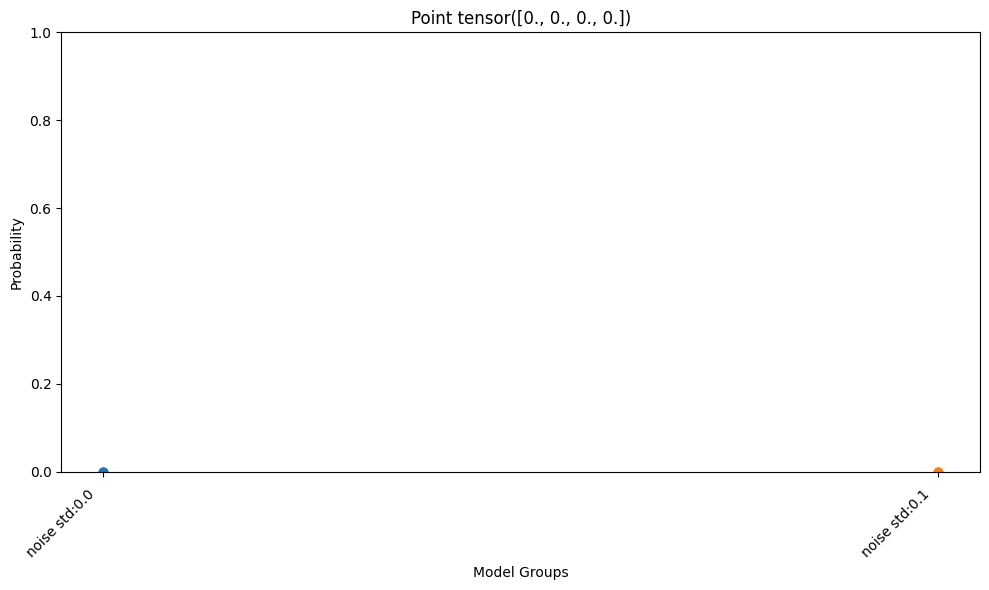

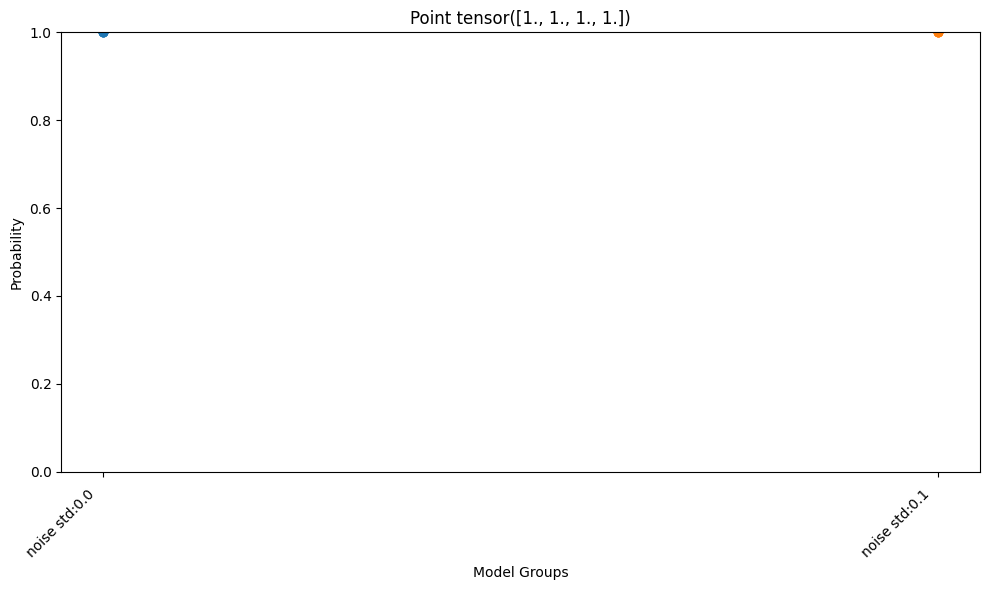

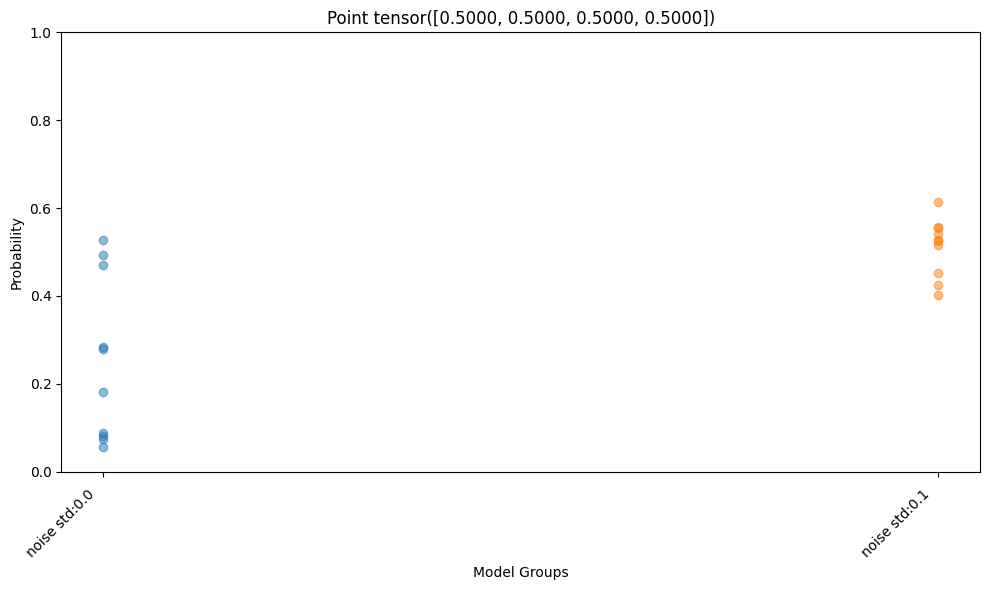

Plots generated for all model groups.


In [ ]:
# Plot the behavior for our test points

# Define test points, the last dims will be cut off if we train with less than 4 dims
test_points = torch.tensor(
    [[0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0], [0.5, 0.5, 0.5, 0.5]]
)


# Group models by their parameters (excluding seed_i)
model_groups = {}
for key, model in models.items():
    # Extract parameters from the key, ignoring seed_i
    params = "__".join(
        [param for param in key.split("__") if not param.startswith("seed_i")]
    )
    if params not in model_groups:
        model_groups[params] = []
    model_groups[params].append((key, model))


# Plot for each group of models
for point_idx, point in enumerate(test_points[:]):
    fig, ax = plt.subplots(figsize=(10, 6))
    for group_index, (params, group) in enumerate(model_groups.items()):
        probs = []
        for _, model in group:
            with torch.no_grad():
                model.cpu()
                n_feat = model[0].in_features
                prob = model(point[None, :n_feat]).softmax(dim=1)[0, 1].item()
                probs.append(prob)

        ax.scatter([group_index] * len(probs), probs, alpha=0.5, label=params)

    ax.set_xlabel("Model Groups")
    ax.set_xticks(range(len(model_groups)))
    ax.set_xticklabels(
        [g_key.replace("_", " ") for g_key in model_groups.keys()],
        rotation=45,
        ha="right",
    )
    ax.set_title(f"Point {point}")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Probability")

    plt.tight_layout()
    plt.show()


print("Plots generated for all model groups.")

<ipython-input-15-bcbdb46f9188>:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


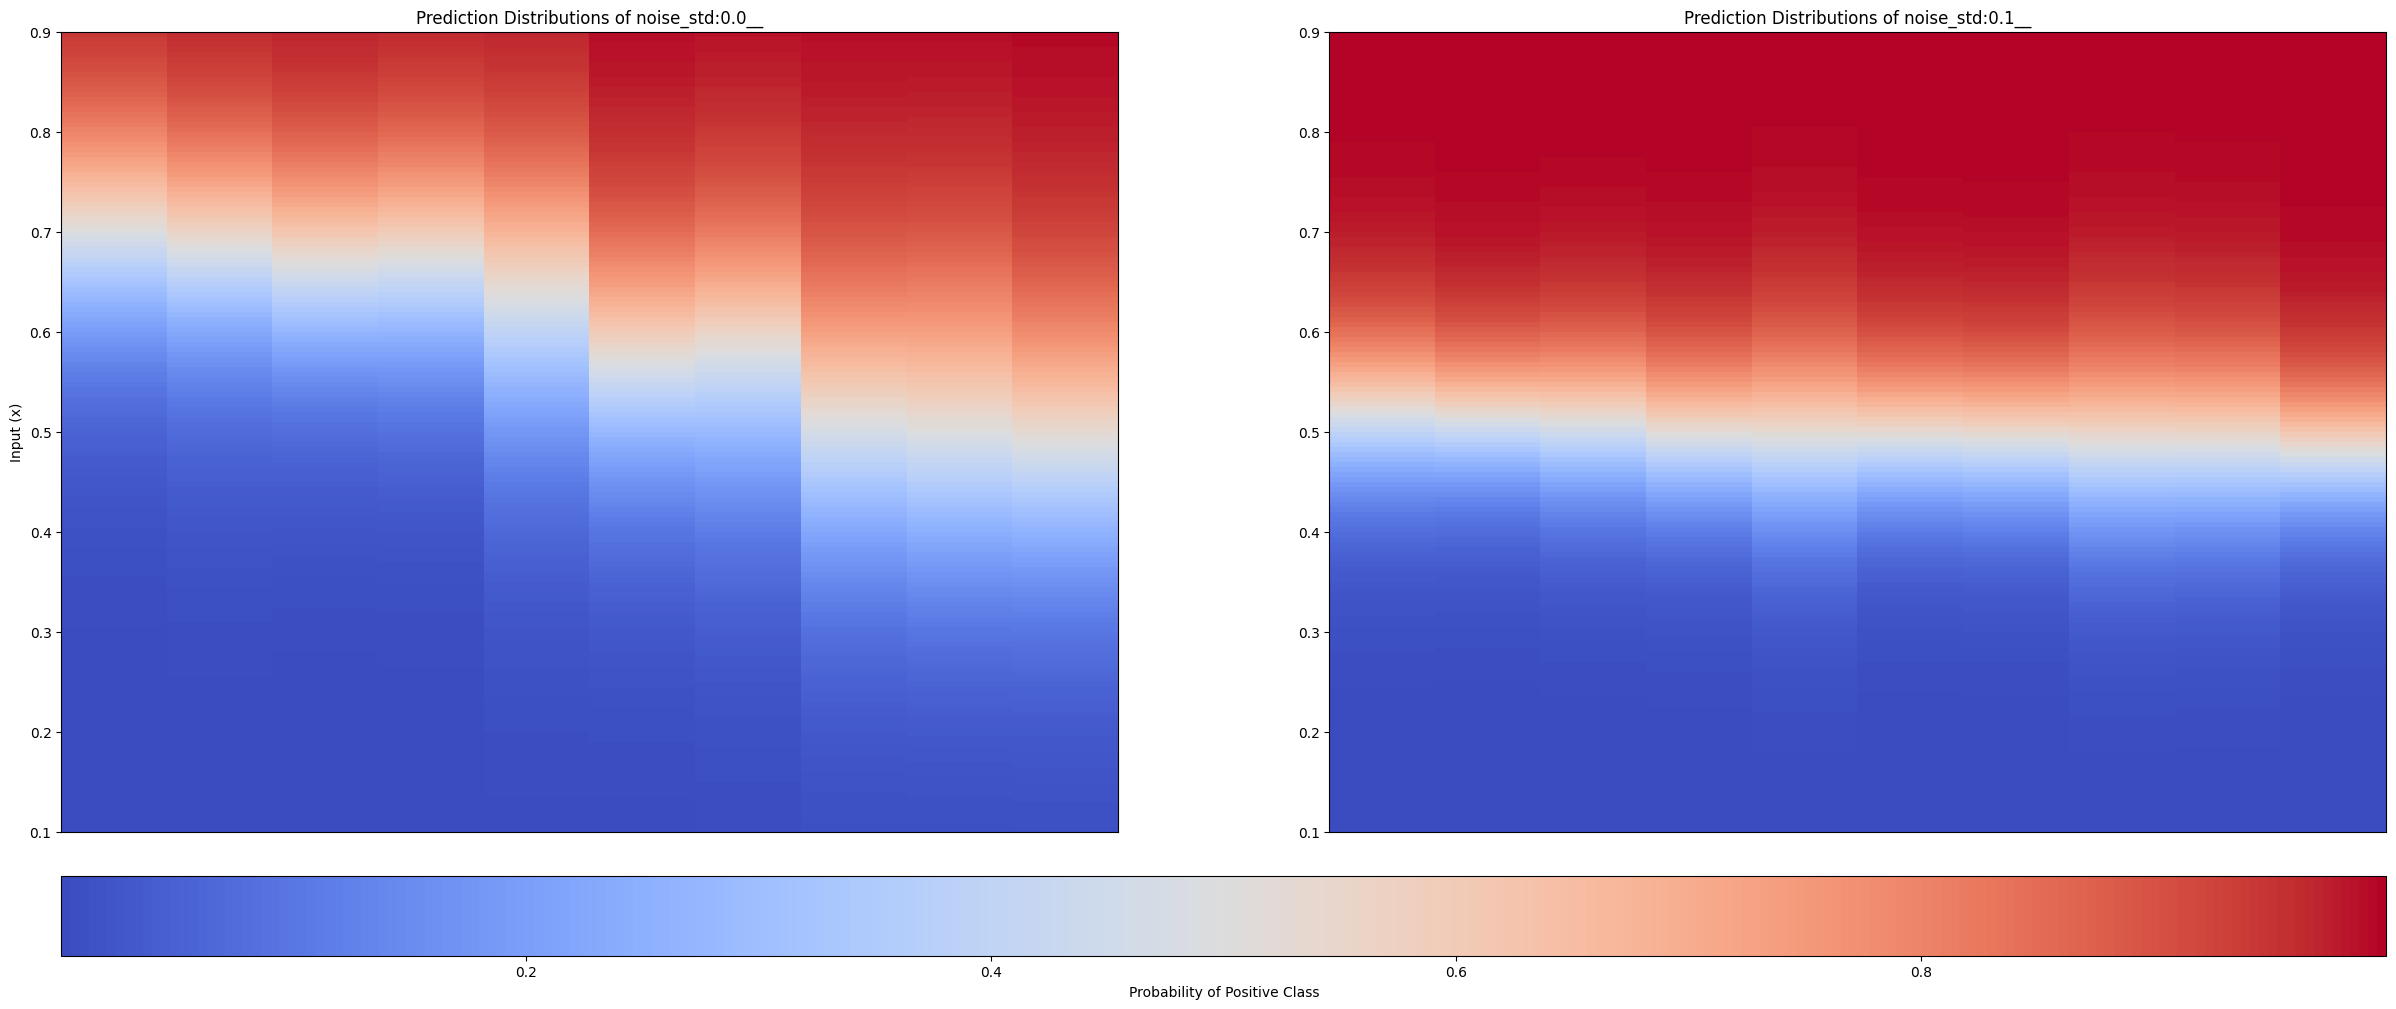

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

x_range = torch.linspace(0.3, 0.7, 200)

# Create the plot
fig = plt.figure(figsize=(30, 12))  # Increased figure height to accommodate colorbar
gs = fig.add_gridspec(2, 2, height_ratios=[20, 2], hspace=0.1)  # 2 rows, 2 columns
axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
]  # Main plots in the top row

keys = (
    model_groups.keys()
)  # ['hidden_size:64__noise_std:0.0__','hidden_size:64__noise_std:0.1__']

for i, (ax, k) in enumerate(zip(axes, keys)):
    mg = model_groups[k]
    with torch.no_grad():
        predictions = [m(x_range[:, None]).softmax(-1) for name, m in mg]
        # sort predictions by their middle prediction
        predictions = sorted(predictions, key=lambda p: p[len(p) // 2][1].item())
    # Stack the predictions into a 2D array
    stacked_predictions = np.stack([p[:, 1].numpy() for p in predictions])

    # Plot for the set of predictions
    im = ax.imshow(
        stacked_predictions.T,
        aspect="auto",
        cmap=sns.color_palette("coolwarm", as_cmap=True),
        extent=[0, len(predictions), 0, 1],
        origin="lower",
    )

    # Customize the plot
    if i == 0:
        ax.set_ylabel("Input (x)")
    # ax.set_xlabel('Model')
    ax.set_xticks([])  # (np.arange(len(predictions)) + 0.5)
    # ax.set_xticklabels([f'Model {j+1}' for j in range(len(predictions))], rotation=45, ha='right')
    ax.set_title("Prediction Distributions of " + k)
    ax.set_ylim(0.1, 0.9)

    # Store the image for colorbar (we'll use the last one)
    im_for_colorbar = im

# Add a colorbar below the plots
cax = fig.add_subplot(gs[1, :])  # Colorbar axis spans the bottom row
cbar = fig.colorbar(im_for_colorbar, cax=cax, orientation="horizontal")
cbar.set_label("Probability of Positive Class")

plt.tight_layout()
plt.show()

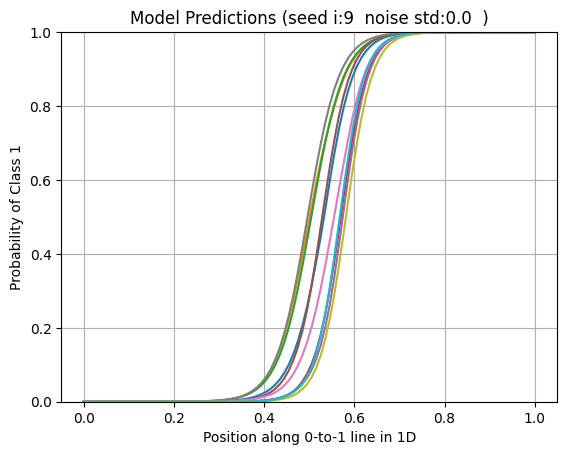

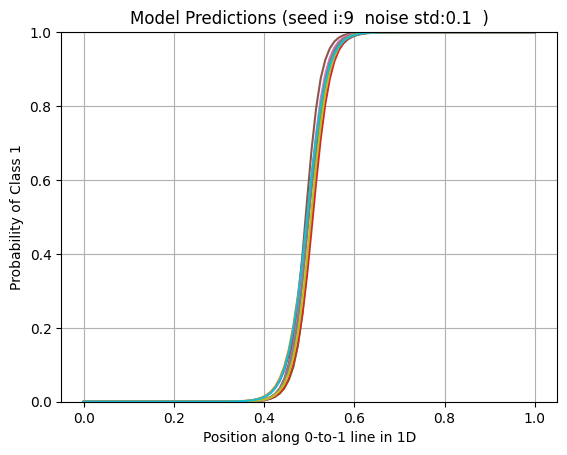

In [ ]:
# Plot predictions for all models
for key, model in models.items():
    if "d:0.0" in key:  #'0.0' in key:
        # plot_model_predictions(model, f"Model Predictions ({key.replace('_',' ')})", save=True)
        plot_model_predictions(
            model, f"Model Predictions ({key.replace('_',' ')})", save=False
        )
plt.show()
for key, model in models.items():
    if "d:0.1" in key:  #'0.0' in key:
        # plot_model_predictions(model, f"Model Predictions ({key.replace('_',' ')})", save=True)
        plot_model_predictions(
            model, f"Model Predictions ({key.replace('_',' ')})", save=False
        )
plt.show()